<a href="https://colab.research.google.com/github/DrAlexSanz/no-mercy/blob/main/AMLD2021_NoMercy_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Dataset**

In [1]:
# Import the NoMercy dataset
!rm -r AMLD2021/
!git clone https://github.com/SamurAi-sarl/AMLD2021.git
!ls -ltr AMLD2021/*

rm: cannot remove 'AMLD2021/': No such file or directory
Cloning into 'AMLD2021'...
remote: Enumerating objects: 6107, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 6107 (delta 2), reused 8 (delta 2), pack-reused 6098
Receiving objects: 100% (6107/6107), 432.29 MiB | 28.52 MiB/s, done.
Resolving deltas: 100% (2152/2152), done.
Checking out files: 100% (2368/2368), done.
-rw-r--r-- 1 root root    408 Sep 29 12:07 AMLD2021/README.md
-rw-r--r-- 1 root root 110453 Sep 29 12:07 AMLD2021/workshop-image.jpg

AMLD2021/dataset:
total 40
drwxr-xr-x 2 root root 20480 Sep 29 12:07 invoice
drwxr-xr-x 2 root root 20480 Sep 29 12:07 registration

AMLD2021/dataset_resized:
total 64
drwxr-xr-x 2 root root 20480 Sep 29 12:07 invoice
drwxr-xr-x 3 root root 24576 Sep 29 12:07 other
drwxr-xr-x 2 root root 20480 Sep 29 12:07 registration

AMLD2021/dataset_test:
total 1812
-rw-r--r-- 1 root root 143902 Sep 29 12:07 ex2.jpeg
-rw-r--r-- 1 root ro

In [2]:
print("jpeg resized images, type invoice:")
!ls AMLD2021/dataset_resized/invoice | wc -l
print("jpeg resized images, type registration:")
!ls AMLD2021/dataset_resized/registration | wc -l
print("jpeg resized images, type other:")
!ls AMLD2021/dataset_resized/other | wc -l

jpeg resized images, type invoice:
436
jpeg resized images, type registration:
417
jpeg resized images, type other:
652


# **Augmented Images**

In [21]:
# Import Augmentor (library to create more distorted images)
!pip install Augmentor
import Augmentor

# Define a function to create augmented images images
def build_augmented_images(path_folder, n_samples):
    p = Augmentor.Pipeline(path_folder)
    p.rotate(probability=0.3, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.3, min_factor=0.5, max_factor=1.3)
    p.zoom_random(probability=0.3, percentage_area=0.8)
    p.skew_tilt(probability=0.3, magnitude=0.3)
    p.random_distortion(probability=0.3, grid_width=4, grid_height=4, magnitude=7)
    p.random_brightness(probability=0.7, min_factor=0.5, max_factor=2.)
    p.random_color(probability=0.3, min_factor=0.6, max_factor=1.4)
    p.random_contrast(probability=0.3, min_factor=0.8, max_factor=1.2)

    p.sample(n_samples, multi_threaded=True)

# Remove previous augmented images, if any (in case you run this notebook more than once) 
!rm -r AMLD2021/dataset_augmented/*
!rm -r AMLD2021/dataset_resized/invoice/output/ 
!rm -r AMLD2021/dataset_resized/registraion/output/
!rm -r AMLD2021/dataset_resized/other/output/

# Number of augmented images, per class
n = 1000   # max 1500 on colab, due to max RAM constraints

# Create augmented images
!mkdir AMLD2021/dataset_augmented/
build_augmented_images('AMLD2021/dataset_resized/invoice', n)
build_augmented_images('AMLD2021/dataset_resized/registration', n)
build_augmented_images('AMLD2021/dataset_resized/other', n)

# Move augmented images to AMLD2021/dataset_augmented/
!mv AMLD2021/dataset_resized/invoice/output      AMLD2021/dataset_augmented/invoice
!mv AMLD2021/dataset_resized/registration/output AMLD2021/dataset_augmented/registration
!mv AMLD2021/dataset_resized/other/output        AMLD2021/dataset_augmented/other

rm: cannot remove 'AMLD2021/dataset_resized/invoice/output/': No such file or directory
rm: cannot remove 'AMLD2021/dataset_resized/registraion/output/': No such file or directory
rm: cannot remove 'AMLD2021/dataset_resized/other/output/': No such file or directory
mkdir: cannot create directory ‘AMLD2021/dataset_augmented/’: File exists
Initialised with 436 image(s) found.
Output directory set to AMLD2021/dataset_resized/invoice/output.

Processing <PIL.Image.Image image mode=RGB size=500x708 at 0x7F3AB02C2BD0>: 100%|██████████| 1000/1000 [01:03<00:00, 15.75 Samples/s]


Initialised with 417 image(s) found.
Output directory set to AMLD2021/dataset_resized/registration/output.

Processing <PIL.Image.Image image mode=RGB size=500x708 at 0x7F39C7220090>: 100%|██████████| 1000/1000 [00:57<00:00, 17.34 Samples/s]


Initialised with 652 image(s) found.
Output directory set to AMLD2021/dataset_resized/other/output.

Processing <PIL.Image.Image image mode=RGB size=500x708 at 0x7F39C7C3B910>: 100%|██████████| 1000/1000 [01:04<00:00, 15.52 Samples/s]


In [23]:
print("Augmented resized images, type invoice")
!ls AMLD2021/dataset_augmented/invoice | wc -l
print("Augmented resized images, type registration")
!ls AMLD2021/dataset_augmented/registration | wc -l
print("Augmented resized images, type other")
!ls AMLD2021/dataset_augmented/other | wc -l

Augmented resized images, type invoice
1000
Augmented resized images, type registration
1000
Augmented resized images, type other
1000


# **Data Preparation**

In [24]:
import os

file_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
keep_labels     = ['invoice','registration', 'other']

def list_files(indir=os.getcwd(),valid_extensions=file_extensions,valid_labels=keep_labels):
    for (rootdir,dirs,files) in os.walk(indir):
        for filename in files:
            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()
            
            # check to see if the file is an image and should be processed
            if valid_extensions is None or ext.endswith(valid_extensions):
                
                # construct the path to the image and yield it
                imagePath = os.path.join(rootdir, filename)
                
                # yield the path if the label should not be dropped 
                if imagePath.split(os.path.sep)[-2] in valid_labels:
                    yield imagePath
            
    return

###**Create Dataset**

Reading images from disk. This may take a while ... 


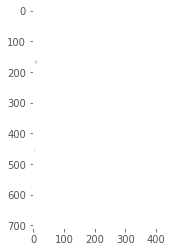

Augmented Image
---------------------


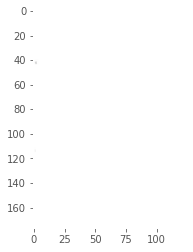

Resized augmented Image
---------------------


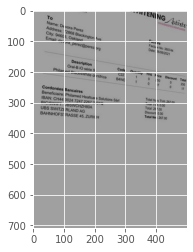

Augmented Image
---------------------


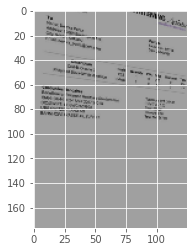

Resized augmented Image
---------------------


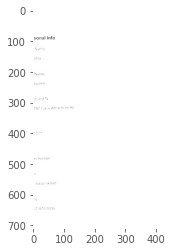

Augmented Image
---------------------


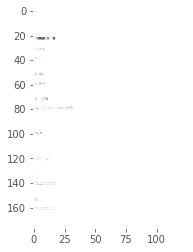

Resized augmented Image
---------------------


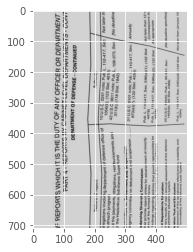

Augmented Image
---------------------


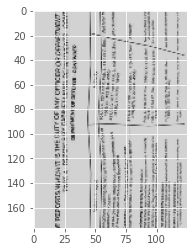

Resized augmented Image
---------------------


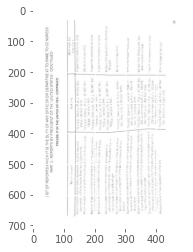

Augmented Image
---------------------


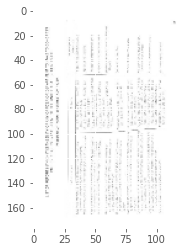

Resized augmented Image
---------------------


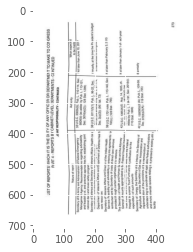

Augmented Image
---------------------


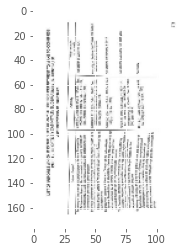

Resized augmented Image
---------------------


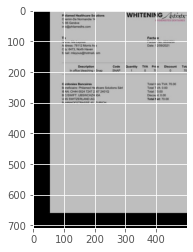

Augmented Image
---------------------


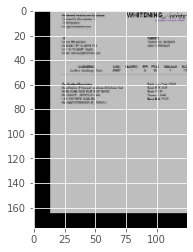

Resized augmented Image
---------------------


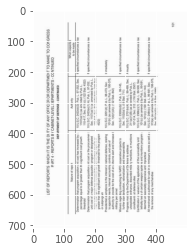

Augmented Image
---------------------


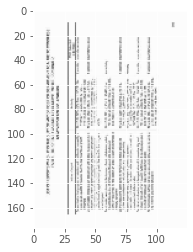

Resized augmented Image
---------------------


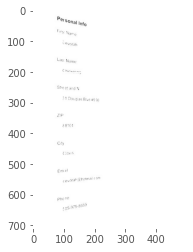

Augmented Image
---------------------


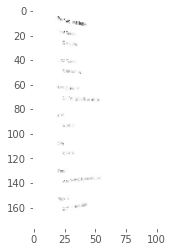

Resized augmented Image
---------------------
1000 images imported
2000 images imported
3000 images imported
---------------------
label: other counts: 1000
label: invoice counts: 1000
label: registration counts: 1000


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io
import random
import cv2


dataset_path = 'AMLD2021/dataset_augmented/'
    
# obtain image paths and ramdomize it
image_paths = list(list_files(dataset_path))
random.seed(42)
random.shuffle(image_paths)
    
# initialize data and labels list
data, labels, count = [],[],0

# resize
RESIZE = 125, 177
#RESIZE = 100, 150
#RESIZE = 83, 118 

print("Reading images from disk. This may take a while ... ")    
for i in image_paths:

    # get image label from parent folder name
    label = i.split(os.path.sep)[-2]
    
    # count images processes and append list with labels
    count+=1
    labels.append(label)

    # load the image and store the image in the data list
    image = cv2.imread(i)
    image = cv2.resize(image, RESIZE)
    data.append(image)

    # show first 10 images before and after resizing
    if count < 10:
      img = io.imread(i)
      plt.imshow(img)
      plt.show()
      print("Augmented Image")
      print("---------------------")
      plt.imshow(image)
      plt.show()
      print("Resized augmented Image")
      print("---------------------")
    
    # show progress
    if ((count % 1000) == 0):
      print( str(count) + " images imported")

# print label count
label_list = os.listdir(dataset_path)
print("---------------------")
for l in label_list: print("label: {} counts: {}".format(l,labels.count(l)))

In [26]:
print("Size of imported X dataset: " + str(len(data)))
print("Size of imported y dataset: " + str(len(labels)))

Size of imported X dataset: 3000
Size of imported y dataset: 3000


###**Train-Test Split**

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split

# convert to np arrays
data = np.array(data,dtype="float")
labels = np.array(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

###**One Hot-Encoding**

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

original_classes = trainY
    
# integer encode
label_encoder = LabelEncoder()
trainY = label_encoder.fit_transform(trainY)
testY  = label_encoder.transform(testY)
    
print(original_classes[0:10])
#print(trainY[0:10])
u, indices = np.unique(trainY, return_index=True)
classes = [original_classes[i] for i in indices]
#print(classes)
  
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
trainY = trainY.reshape(len(trainY), 1)
trainY = onehot_encoder.fit_transform(trainY)
testY = testY.reshape(len(testY), 1)
testY = onehot_encoder.transform(testY)
print(trainY[0:10])

['invoice' 'other' 'invoice' 'other' 'other' 'registration' 'other'
 'other' 'other' 'registration']
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


# **Define Model and Compile**

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import Sequential
from keras.layers import Dropout

In [46]:
INPUT_DROPOUT = 0.0
CONV_DROPOUT = 0.0
DENSE_DROPOUT = 0.2

headmodel = Sequential()

# Input dropout
headmodel.add(Dropout(INPUT_DROPOUT, input_shape=(RESIZE[1], RESIZE[0], 3)))

# Convolutional Layer 1
headmodel.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
headmodel.add(Dropout(CONV_DROPOUT))
headmodel.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
headmodel.add(Conv2D(12, (3, 3), activation='relu', padding='same'))
headmodel.add(Dropout(CONV_DROPOUT))
headmodel.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
headmodel.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
headmodel.add(Dropout(CONV_DROPOUT))
headmodel.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 4
headmodel.add(Conv2D(4, (3, 3), activation='relu', padding='same'))
headmodel.add(Dropout(CONV_DROPOUT))
headmodel.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 5
#headmodel.add(Conv2D(4, (3, 3), activation='relu', padding='same'))
#headmodel.add(Dropout(CONV_DROPOUT))
#headmodel.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 6
#headmodel.add(Conv2D(4, (3, 3), activation='relu', padding='same'))
#headmodel.add(Dropout(CONV_DROPOUT))
#headmodel.add(MaxPooling2D(pool_size=(2, 2)))

headmodel.add(Flatten())

# Dense Layer 1
headmodel.add(Dense(50, activation='relu'))
headmodel.add(Dropout(DENSE_DROPOUT))

# Dense Layer 2
#headmodel.add(Dense(20, activation='relu'))
#headmodel.add(Dropout(DENSE_DROPOUT))

ACTIVATION = 'softmax'   # 'sigmoid'
headmodel.add(Dense(len(classes), activation=ACTIVATION))


#compiling the model
print("Compiling model...")
opt = Adam()
#opt = SGD()
headmodel.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

headmodel.summary()

Compiling model...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_61 (Dropout)         (None, 177, 125, 3)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 177, 125, 16)      1216      
_________________________________________________________________
dropout_62 (Dropout)         (None, 177, 125, 16)      0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 88, 62, 16)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 88, 62, 12)        1740      
_________________________________________________________________
dropout_63 (Dropout)         (None, 88, 62, 12)        0         
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None

#**Train Model**

In [47]:
# define early stopping callback
callback= EarlyStopping(
          monitor="val_loss",
          patience=20,
          mode="auto",
          restore_best_weights=True,
          )

# initialize # of epochs and batch size
EPOCHS = 30

#BS = 128
BS = 64
#BS = 32

# train the network
H = headmodel.fit(trainX, trainY, 
                  validation_data=(testX, testY), 
                  epochs=EPOCHS, 
                  batch_size=BS, 
                  callbacks = [callback],)

Epoch 1/30
36/36 [==============================] - 3s 64ms/step - loss: 3.2127 - accuracy: 0.5036 - val_loss: 0.8916 - val_accuracy: 0.7067
Epoch 2/30
36/36 [==============================] - 2s 53ms/step - loss: 0.6682 - accuracy: 0.7404 - val_loss: 0.3841 - val_accuracy: 0.8733
Epoch 3/30
36/36 [==============================] - 2s 53ms/step - loss: 0.3667 - accuracy: 0.8627 - val_loss: 0.2520 - val_accuracy: 0.9107
Epoch 4/30
36/36 [==============================] - 2s 54ms/step - loss: 0.2807 - accuracy: 0.9027 - val_loss: 0.2111 - val_accuracy: 0.9200
Epoch 5/30
36/36 [==============================] - 2s 53ms/step - loss: 0.2277 - accuracy: 0.9178 - val_loss: 0.1711 - val_accuracy: 0.9333
Epoch 6/30
36/36 [==============================] - 2s 54ms/step - loss: 0.1903 - accuracy: 0.9280 - val_loss: 0.1809 - val_accuracy: 0.9360
Epoch 7/30
36/36 [==============================] - 2s 54ms/step - loss: 0.1813 - accuracy: 0.9356 - val_loss: 0.1343 - val_accuracy: 0.9507
Epoch 8/30
36

##**Evaluate Performance**

Evaluating model on train set
              precision    recall  f1-score   support

     invoice       0.98      1.00      0.99       764
       other       1.00      0.97      0.99       764
registration       0.99      1.00      1.00       722

    accuracy                           0.99      2250
   macro avg       0.99      0.99      0.99      2250
weighted avg       0.99      0.99      0.99      2250

Evaluating model on validation set
              precision    recall  f1-score   support

     invoice       0.95      0.99      0.97       236
       other       0.97      0.93      0.95       236
registration       0.98      0.97      0.97       278

    accuracy                           0.97       750
   macro avg       0.96      0.96      0.96       750
weighted avg       0.97      0.97      0.97       750



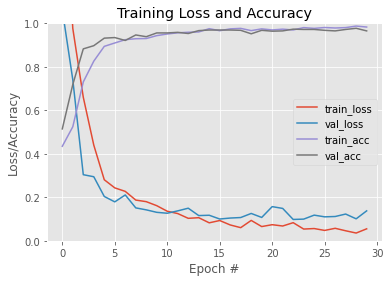

In [44]:
import matplotlib
matplotlib.use("Agg")

# evaluate the network
print("Evaluating model on train set")
predictions = headmodel.predict(x=trainX)
print(classification_report(trainY.argmax(axis=1),predictions.argmax(axis=1), target_names=classes))

print("Evaluating model on validation set")
predictions = headmodel.predict(x=testX)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=classes))
    
# plot the training loss and accuracy
N = np.arange(0, len(H.history["loss"]))
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

#**Test on uploaded images**

Take your own photos of the documents with your phone.

Upload the photos in AMLD2021/dataset_test/ on Colab (click on the folder icon on the left).

The following cell will show predictions on all images in this folder.

['AMLD2021/dataset_test/IMG_20210929_144042.jpg', 'AMLD2021/dataset_test/IMG_20210929_144037.jpg', 'AMLD2021/dataset_test/IMG_20210929_144129.jpg', 'AMLD2021/dataset_test/IMG_20210929_144116.jpg', 'AMLD2021/dataset_test/ex7.jpeg', 'AMLD2021/dataset_test/ex4.jpeg', 'AMLD2021/dataset_test/IMG_20210929_144143.jpg', 'AMLD2021/dataset_test/ex5.jpeg', 'AMLD2021/dataset_test/ex2.jpeg', 'AMLD2021/dataset_test/ex1.jpeg', 'AMLD2021/dataset_test/IMG_20210929_144126.jpg', 'AMLD2021/dataset_test/ex3.jpeg', 'AMLD2021/dataset_test/ex6.jpeg', 'AMLD2021/dataset_test/IMG_20210929_144059.jpg']
[INFO] Reading images from disk. This may take a while ... 


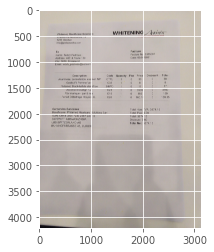

Prob. Invoice:      0.8838238
Prob. Other:        0.11617618
Prob. Registration: 6.5825445e-16
Uploaded Image: AMLD2021/dataset_test/IMG_20210929_144042.jpg
---------------------


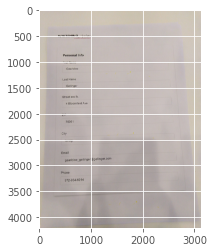

Prob. Invoice:      2.7954591e-14
Prob. Other:        2.911922e-07
Prob. Registration: 0.99999976
Uploaded Image: AMLD2021/dataset_test/IMG_20210929_144037.jpg
---------------------


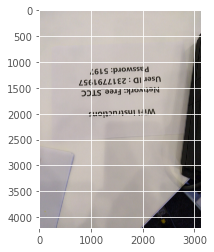

Prob. Invoice:      5.550589e-10
Prob. Other:        1.0
Prob. Registration: 2.0890621e-19
Uploaded Image: AMLD2021/dataset_test/IMG_20210929_144129.jpg
---------------------


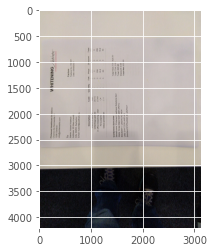

Prob. Invoice:      0.018223314
Prob. Other:        0.9817732
Prob. Registration: 3.5002806e-06
Uploaded Image: AMLD2021/dataset_test/IMG_20210929_144116.jpg
---------------------


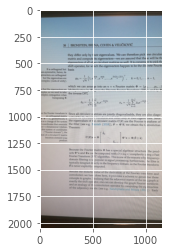

Prob. Invoice:      6.72116e-10
Prob. Other:        1.0
Prob. Registration: 4.510579e-12
Uploaded Image: AMLD2021/dataset_test/ex7.jpeg
---------------------


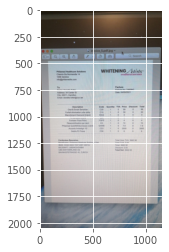

Prob. Invoice:      0.0019138322
Prob. Other:        0.9980862
Prob. Registration: 1.0361634e-09
Uploaded Image: AMLD2021/dataset_test/ex4.jpeg
---------------------


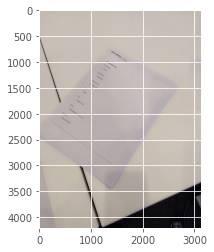

Prob. Invoice:      8.421263e-07
Prob. Other:        0.8986671
Prob. Registration: 0.10133201
Uploaded Image: AMLD2021/dataset_test/IMG_20210929_144143.jpg
---------------------


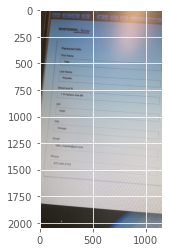

Prob. Invoice:      3.8245144e-05
Prob. Other:        0.83970076
Prob. Registration: 0.160261
Uploaded Image: AMLD2021/dataset_test/ex5.jpeg
---------------------


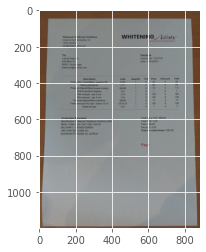

Prob. Invoice:      0.7265222
Prob. Other:        0.27347776
Prob. Registration: 7.7644335e-11
Uploaded Image: AMLD2021/dataset_test/ex2.jpeg
---------------------


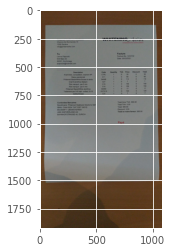

Prob. Invoice:      0.31250685
Prob. Other:        0.6874931
Prob. Registration: 8.1413176e-10
Uploaded Image: AMLD2021/dataset_test/ex1.jpeg
---------------------


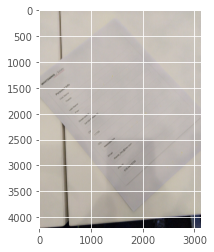

Prob. Invoice:      6.2774296e-07
Prob. Other:        0.55199265
Prob. Registration: 0.44800672
Uploaded Image: AMLD2021/dataset_test/IMG_20210929_144126.jpg
---------------------


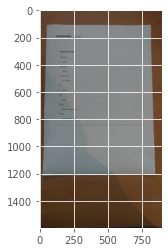

Prob. Invoice:      0.0007446857
Prob. Other:        0.8643521
Prob. Registration: 0.1349033
Uploaded Image: AMLD2021/dataset_test/ex3.jpeg
---------------------


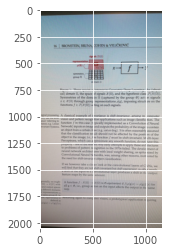

Prob. Invoice:      3.4592443e-07
Prob. Other:        0.99977607
Prob. Registration: 0.00022353644
Uploaded Image: AMLD2021/dataset_test/ex6.jpeg
---------------------


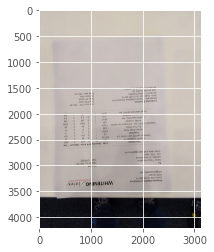

Prob. Invoice:      1.4792377e-08
Prob. Other:        1.0
Prob. Registration: 2.3917224e-10
Uploaded Image: AMLD2021/dataset_test/IMG_20210929_144059.jpg
---------------------


In [48]:
%matplotlib inline
upload_path = 'AMLD2021/dataset_test/'

def list_files_test(indir=os.getcwd()):
    for (rootdir,dirs,files) in os.walk(indir):
        for filename in files:
            yield upload_path + filename

uploadX = list(list_files_test(upload_path))
print(uploadX)



print("[INFO] Reading images from disk. This may take a while ... ")    
for i in uploadX:
    # show image
    img = io.imread(i)
    plt.imshow(img)
    plt.show()

    # load the image and store the image in the data list
    image = cv2.imread(i)
    image = cv2.resize(image, RESIZE)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    pred = headmodel.predict(image)
    print("Prob. Invoice:      " + str(pred[0][0]))
    print("Prob. Other:        " + str(pred[0][1]))
    print("Prob. Registration: " + str(pred[0][2]))
    print("Uploaded Image: " + i)
    print("---------------------")

#**Exercise 1: Model Tuning**

* Hyper-parameter tuning and feature engineering:
 * Number of augmented images (max 1.5k per class)
 * CNN layers, filters, dropout
 * Dense layers, number of nodes, dropout
 * Optimizer, Batch size, Num. of Epochs
 * Resize of the images (up in the data preparation)
* Goal: reach an accuracy of > 99% on the training and validation sets



#**Exercise 2: Human In The Loop**

* Make photos of several documents (~5-10 per class)
 * jpeg format is perfect
 * Advice: name the images according to their class (my_invoice_1.jpg). This will help for the rest of the exercise
* Upload them on Colab and copy them to the right folder for re-training (for example AMLD2021/dataset_resize/invoice/ for invoices)
 * example: !cp my_invoice_* AMLD2021/dataset_resize/invoice/
* Re-build augmented images, retrain the model, and re-evaluate performance